В данной работе рассмотрено выделение кластера
типичных значений и кластера 'блестящих точек' на изображение импульсной
ЭПР методом k-средних. Построение разделяющей границы и
полосы для различных значений параметра регуляризации и функций ядра
скалярного преобразования.

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io

# Ah64

In [2]:
mat = scipy.io.loadmat('Ah64.mat')

In [3]:
data_fr = pd.DataFrame(data = {'Time' : mat['Time'].transpose()[0],
                              'Brightness' : mat['Brightness'].transpose()[0]})
data_fr.head()

,Time,Brightness
0,29.17,-30.33
1,28.28,-35.23
2,29.39,-38.24
3,28.56,-35.23
4,27.67,-41.25


Для генерирования классификатора на основе машины опорных векторов
необходимо произвести разметку кластеров. Разметку кластеров произведём с
помощью метода kmeans. 

In [4]:
a = np.array([data_fr['Time'].values])
b = np.array([data_fr['Brightness'].values])
featureArr = np.vstack((a, b)).T

In [6]:
kmeans = KMeans(n_clusters = 2, random_state = 0).fit(featureArr)

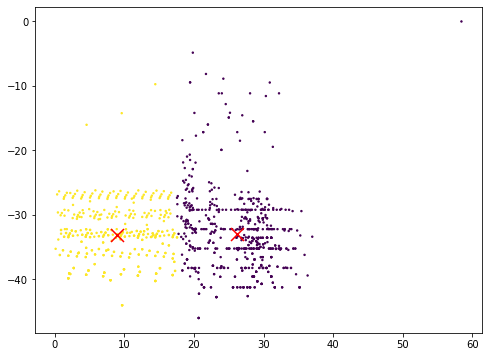

In [7]:
plt.figure(figsize=(8, 6))
plt.scatter(data_fr['Time'], data_fr['Brightness'], c = kmeans.labels_, s = 2)

centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=4,
            color='r', zorder=10)

plt.show()

In [8]:
data_fr['label'] = kmeans.labels_
data_fr = data_fr[['label', 'Time', 'Brightness']]
data_fr.head()

,label,Time,Brightness
0,0,29.17,-30.33
1,0,28.28,-35.23
2,0,29.39,-38.24
3,0,28.56,-35.23
4,0,27.67,-41.25


SVM классификатор с линейной и полиномиальной функцией ядра 
скалярного произведения.

In [9]:
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import cross_val_predict 
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import confusion_matrix 

In [55]:
X = data_fr[data_fr.columns[1:]]
Y = data_fr['label']

In [56]:
transformer = StandardScaler().fit(X) 
X = transformer.transform(X)

In [57]:
kfold = KFold(n_splits = 10) 
means_ = []
accuracy = []
classifiers = ['Linear Svm', 'Poly Svm']
models = [SVC(kernel = 'linear'),
          SVC(kernel = 'poly')]
for i in models:
    model = i
    cv_result = cross_val_score(model, X, Y, cv = kfold, scoring = "accuracy")
    cv_result = cv_result
    means_.append(cv_result.mean())
    accuracy.append(cv_result)
new_models_dataframe2 = pd.DataFrame({'CV Mean' : means_}, index = classifiers)       
new_models_dataframe2

,CV Mean
Linear Svm,0.983178
Poly Svm,0.916822


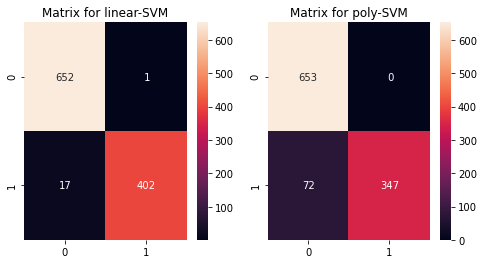

In [58]:
f, ax = plt.subplots(1, 2, figsize=(8, 4))
y_pred = cross_val_predict(SVC(kernel = 'linear'), X, Y, cv = 10)
sns.heatmap(confusion_matrix(Y, y_pred), ax = ax[0], annot = True, fmt = '2.0f')
ax[0].set_title('Matrix for linear-SVM')
y_pred = cross_val_predict(SVC(kernel = 'poly'), X, Y, cv = 10)
sns.heatmap(confusion_matrix(Y, y_pred),ax = ax[1],annot = True, fmt = '2.0f')
ax[1].set_title('Matrix for poly-SVM')
plt.show()

In [66]:
def plot_svm(data_fr, cv_result):
    
    plt.figure(figsize=(6, 4))
    plt.scatter(data_fr['Time'], data_fr['Brightness'], c = data_fr['label'], s = 2)

    # plot the decision function
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    X = data_fr[data_fr.columns[1:]]
    Y = data_fr['label']
    cv_result.fit(X, Y)
    Z = cv_result.decision_function(xy).reshape(XX.shape)

    # plot decision boundary and margins
    ax.contour(XX, YY, Z, colors = 'r', levels = [-1, 0, 1], alpha = 0.5,
               linestyles = ['--', '-', '--'])
    # plot support vectors
    ax.scatter(cv_result.support_vectors_[:, 0], cv_result.support_vectors_[:, 1], s = 1,
               linewidth = 1, facecolors = 'none', edgecolors = 'g')
    plt.show()

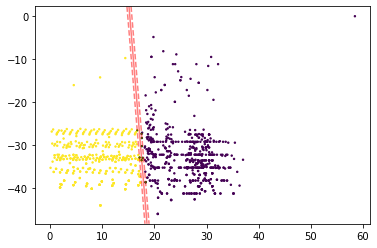

In [67]:
cv_result = SVC(kernel='linear')
plot_svm(data_fr, cv_result)

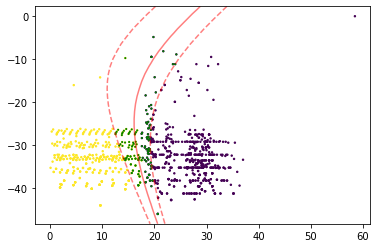

In [68]:
cv_result = SVC(kernel='poly')
plot_svm(data_fr, cv_result)

SVM классификатор и подбор гиперпапарметров

In [69]:
from sklearn.model_selection import GridSearchCV

In [79]:
C = [0.1, 0.5, 1, 10, 20]
gamma = [0.1, 0.3, 0.5, 0.8, 1.0]
kernel = ['linear', 'poly']
hyper = {'kernel' : kernel, 'C' : C, 'gamma' : gamma}
gd = GridSearchCV(estimator = SVC(), param_grid = hyper, verbose = True)
gd.fit(X, Y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.9616822429906542
SVC(C=0.1, gamma=0.1, kernel='linear')


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    2.7s finished


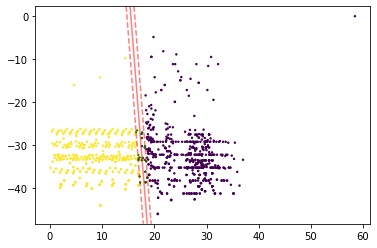

In [80]:
cv_result = gd.best_estimator_
plot_svm(data_fr, cv_result)

# Tomahavk

In [81]:
mat = scipy.io.loadmat('Tomahavk.mat')

In [82]:
data_fr = pd.DataFrame(data = {'Time' : mat['Time'].transpose()[0],
                              'Brightness' : mat['Brightness'].transpose()[0]})
data_fr.head()

,Time,Brightness
0,5.00,-41.56
1,4.69,-32.53
2,4.69,-38.55
3,4.88,-32.53
4,4.88,-29.52


In [83]:
a = np.array([data_fr['Time'].values])
b = np.array([data_fr['Brightness'].values])
featureArr = np.vstack((a, b)).T

In [84]:
kmeans = KMeans(n_clusters = 2, random_state = 0).fit(featureArr)

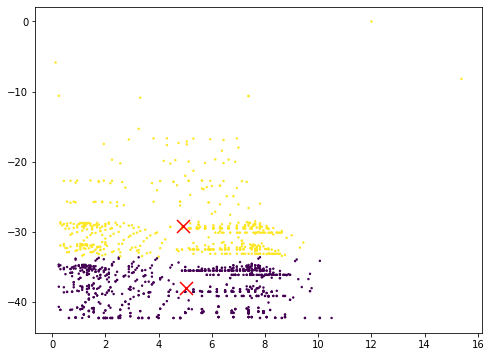

In [85]:
plt.figure(figsize=(8, 6))
plt.scatter(data_fr['Time'], data_fr['Brightness'], c = kmeans.labels_, s = 2)

centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=4,
            color='r', zorder=10)

plt.show()

In [86]:
data_fr['label'] = kmeans.labels_
data_fr = data_fr[['label', 'Time', 'Brightness']]
data_fr.head()

,label,Time,Brightness
0,0,5.00,-41.56
1,1,4.69,-32.53
2,0,4.69,-38.55
3,1,4.88,-32.53
4,1,4.88,-29.52


In [87]:
X = data_fr[data_fr.columns[1:]]
Y = data_fr['label']

In [88]:
transformer = StandardScaler().fit(X) 
X = transformer.transform(X)

In [89]:
kfold = KFold(n_splits = 10) 
means_ = []
accuracy = []
classifiers = ['Linear Svm', 'Poly Svm']
models = [SVC(kernel = 'linear'),
          SVC(kernel = 'poly')]
for i in models:
    model = i
    cv_result = cross_val_score(model, X, Y, cv = kfold, scoring = "accuracy")
    cv_result = cv_result
    means_.append(cv_result.mean())
    accuracy.append(cv_result)
new_models_dataframe2 = pd.DataFrame({'CV Mean' : means_}, index = classifiers)       
new_models_dataframe2

,CV Mean
Linear Svm,0.994595
Poly Svm,0.948086


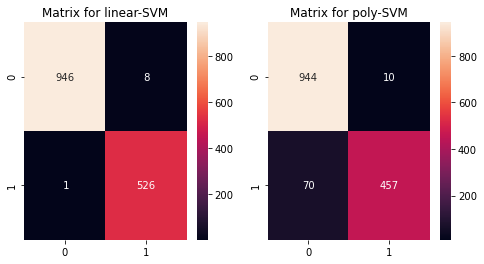

In [90]:
f, ax = plt.subplots(1, 2, figsize=(8, 4))
y_pred = cross_val_predict(SVC(kernel = 'linear'), X, Y, cv = 10)
sns.heatmap(confusion_matrix(Y, y_pred), ax = ax[0], annot = True, fmt = '2.0f')
ax[0].set_title('Matrix for linear-SVM')
y_pred = cross_val_predict(SVC(kernel = 'poly'), X, Y, cv = 10)
sns.heatmap(confusion_matrix(Y, y_pred),ax = ax[1],annot = True, fmt = '2.0f')
ax[1].set_title('Matrix for poly-SVM')
plt.show()

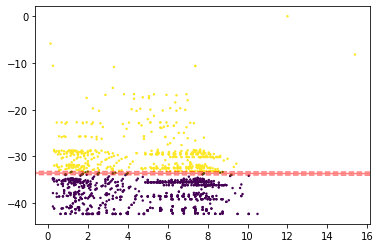

In [91]:
cv_result = SVC(kernel='linear')
plot_svm(data_fr, cv_result)

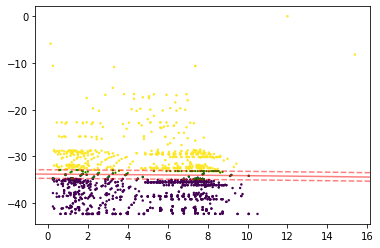

In [92]:
cv_result = SVC(kernel='poly')
plot_svm(data_fr, cv_result)

In [93]:
C = [0.1, 0.5, 1, 10, 20]
gamma = [0.1, 0.3, 0.5, 0.8, 1.0]
kernel = ['linear', 'poly']
hyper = {'kernel' : kernel, 'C' : C, 'gamma' : gamma}
gd = GridSearchCV(estimator = SVC(), param_grid = hyper, verbose = True)
gd.fit(X, Y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.9932432432432432
SVC(C=10, gamma=0.1, kernel='linear')


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    3.6s finished


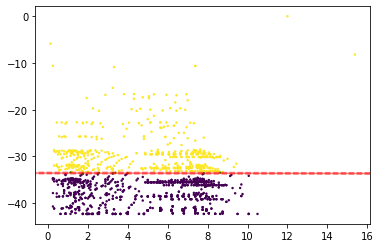

In [94]:
cv_result = gd.best_estimator_
plot_svm(data_fr, cv_result)